In [3]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'

### Truth file settings
truthFileName='../data/proc/truth.nc'

### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    obsFilePath='../data/raw/'
    modFilePath='../data/raw/'
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
obsPrefix = 'obs_'
modPrefix = 'eac_mod_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [4]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    etaRange=range(etaRange[0],etaRange[1]+1)
    xiRange=range(xiRange[0],xiRange[1]+1)
    output = input.isel(eta_rho=etaRange, xi_rho=xiRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMap(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa 

### First look at finalised obs file.
These are the mod files that have noise added in matlab and renamed, then used for the OSSE

In [24]:
### Load osse obs and mod file data
obsFileName = '08005.nc'

obsPath = obsFilePath+obsPrefix+obsFileName

obs = xr.open_dataset(obsPath)


In [6]:
ssh_prov=(406,401,402,403,404,405)
obs

<xarray.Dataset>
Dimensions:         (datum: 184097, state_variable: 7, survey: 76)
Dimensions without coordinates: datum, state_variable, survey
Data variables: (12/16)
    spherical       int32 ...
    Nobs            (survey) int32 ...
    survey_time     (survey) float64 ...
    obs_variance    (state_variable) float64 ...
    obs_type        (datum) int32 ...
    obs_time        (datum) float64 ...
    ...              ...
    obs_error       (datum) float64 ...
    obs_value       (datum) float64 ...
    obs_meta        (datum) float64 ...
    obs_provenance  (datum) int32 ...
    obs_lat         (datum) float64 ...
    obs_lon         (datum) float64 ...
Attributes:
    title:            Observations
    author:           David Gwyther
    date:             11-May-2021 15:37:06
    type:             ROMS observations
    Conventions:      CF-1.4
    state_variables:  \n1: free-surface (m) \n2: vertically integrated u-mome...

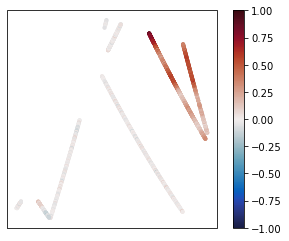

In [7]:

v=obs.obs_value.where(obs.obs_provenance==405).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==405).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)
la=obs.obs_lat.where(obs.obs_provenance==405).where((obs.obs_time>8005) & (obs.obs_time<8006), drop=True)


fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
ax = plt.scatter(x=lo,y=la,c=v,marker='.',cmap = cmaps.cmocean_balance, vmin=-1, vmax=1)
ax = plt.colorbar()

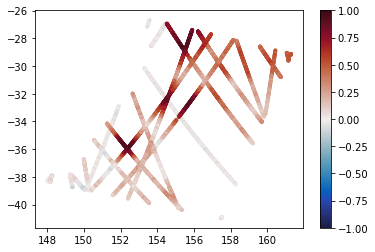

In [8]:

# obs.where(obs.obs_provenance==405).plot.scatter(x='obs_lon',y='obs_lat',c='obs_value')

tRange=[8005,8006]
plt.scatter(x=obs.obs_lon.where(obs.obs_provenance==405),y=obs.obs_lat.where(obs.obs_provenance==405),c=obs.obs_value.where(obs.obs_provenance==405),marker='.',cmap=cmaps.cmocean_balance, vmin=-1, vmax=1)
plt.colorbar()

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009


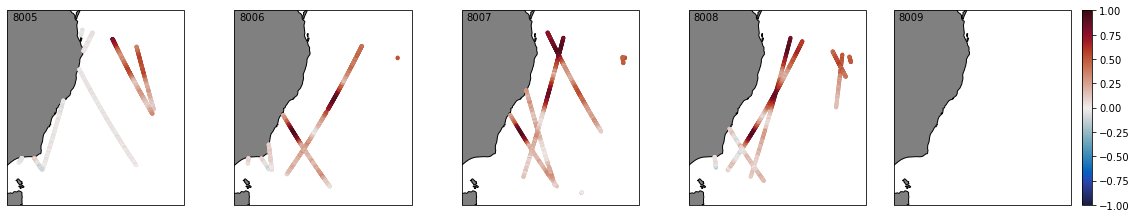

In [9]:
tRange=np.arange(8005,8013,1)
pRange=(405)

fig, axes = plt.subplots(ncols=5, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
    ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
# fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
plt.tight_layout()
fig.colorbar(sc)

In [10]:
tRange=np.arange(8005,8053,4)
tRange

array([8005, 8009, 8013, 8017, 8021, 8025, 8029, 8033, 8037, 8041, 8045,
       8049])

opening 08005.nc
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8006
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8007
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8008
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009
opening 08009.nc
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8009
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8010
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8011
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8012
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8013


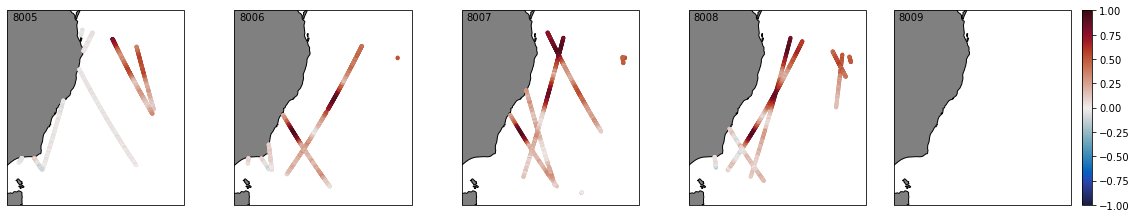

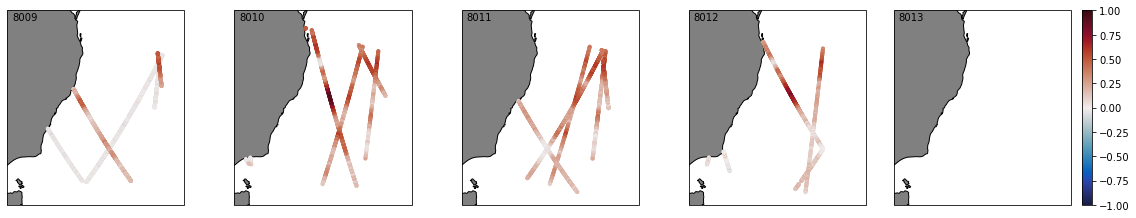

In [11]:
dStart=8005
dEnd=8009+4
assimPeriod = 5
assimOverlap = 1

pRange=(405)


for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    obsFileName = '0'+str(day)+'.nc'
    obsPath = obsFilePath+obsPrefix+obsFileName
    modPath = modFilePath+modPrefix+obsFileName 
    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRange=np.arange(day,day+assimPeriod,1)

    fig, axes = plt.subplots(ncols=assimPeriod, figsize=(16, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    for ax, tRangeStart in zip(axes, tRange):
        print(type(ax), tRangeStart)
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
        ax.text(.1,.95,str(tRangeStart),horizontalalignment='center',transform=ax.transAxes)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    fig.colorbar(sc)

opening 08005.nc
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 0 1
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 1 2
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 2 3
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 3 4
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 4 5
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 5 6
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 6 7
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 7 8
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8 9
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 9 10
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 10 11
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 11 12
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 12 13
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 13 14
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 14 15
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 15 16
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 16 17
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 17 18
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 18 19
<class 'cartopy.mpl.geoaxes.GeoAx

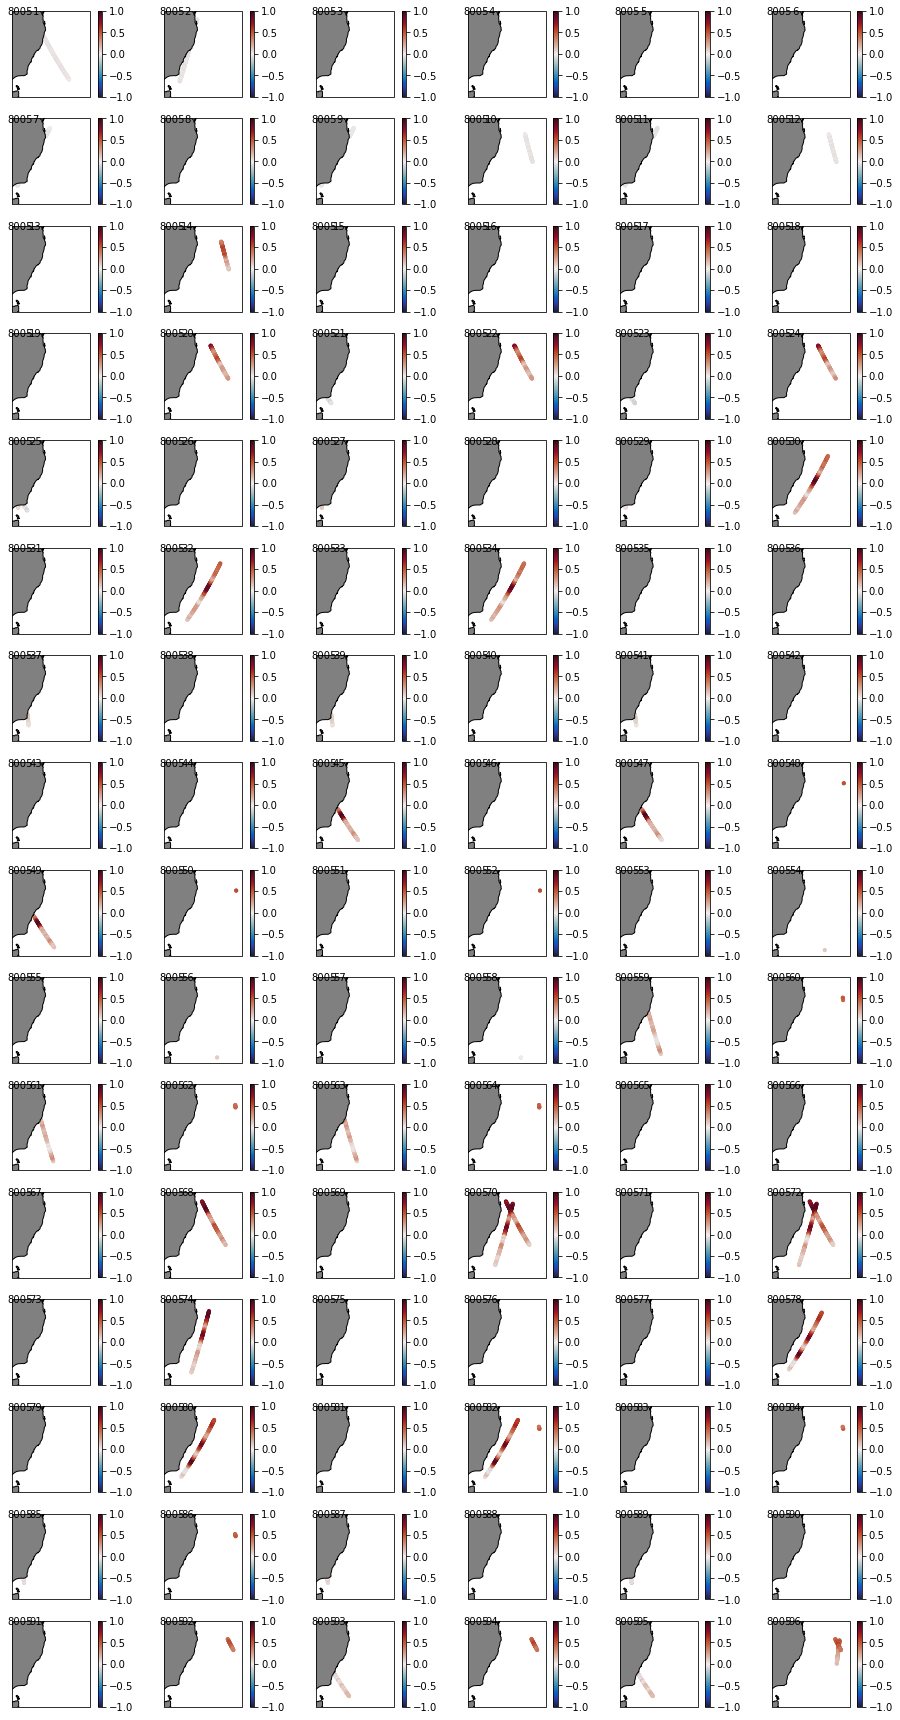

In [12]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)


for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    obsFileName = '0'+str(day)+'.nc'
    obsPath = obsFilePath+obsPrefix+obsFileName
    modPath = modFilePath+modPrefix+obsFileName 
    print('opening '+obsFileName)
    obs = xr.open_dataset(obsPath)

    tRangeStart=np.arange(day,day+assimPeriod,1/24)
    tRangeEnd=np.arange(day+1/24,day+assimPeriod+1/24,1/24)

    fig = plt.figure(figsize=(13,24))
    iSz,jSz = (16,6)
    gs = fig.add_gridspec(iSz, jSz)

    for ax, tStart, tEnd in zip(range(iSz*jSz), tRangeStart, tRangeEnd):
        ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
        print(type(ax), round((tStart-tRangeStart[0])*24), round((tEnd-tRangeStart[0])*24))
        v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tStart) & (obs.obs_time<tEnd), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)#, vmin=-1, vmax=1, zorder=10)
        ax.text(.3,.95,str(round((tEnd-tRangeStart[0])*24)),horizontalalignment='center',transform=ax.transAxes)
        ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
        cb = fig.colorbar(sc)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('temp.png')


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


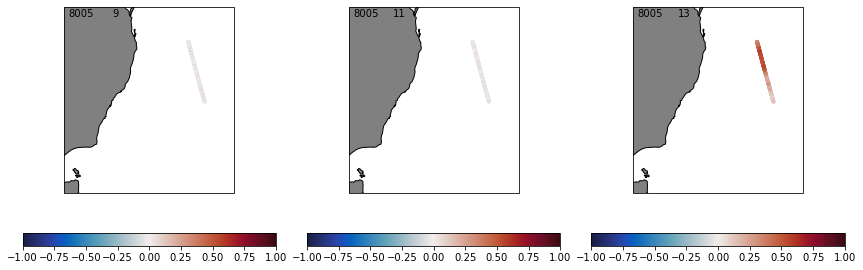

In [13]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


8005.375
<xarray.DataArray 'obs_value' ()>
array(-0.00373272)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(2.08287068e-05)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36080035)


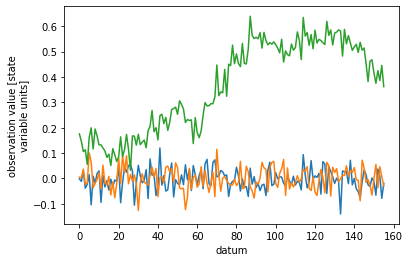

In [14]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())


### Now look at difference between mod file and finalised obs file.
These are the outputs from the Truth run: model values assessed at input obs points.

In [15]:
### Load osse obs and mod file data
modFileName = '08005.nc'

modPath = modFilePath+modPrefix+modFileName

mod = xr.open_dataset(modPath)


opening 08005.nc
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 0 1
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 1 2
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 2 3
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 3 4
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 4 5
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 5 6
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 6 7
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 7 8
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8 9
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 9 10
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 10 11
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 11 12
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 12 13
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 13 14
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 14 15
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 15 16
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 16 17
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 17 18
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 18 19
<class 'cartopy.mpl.geoaxes.GeoAx

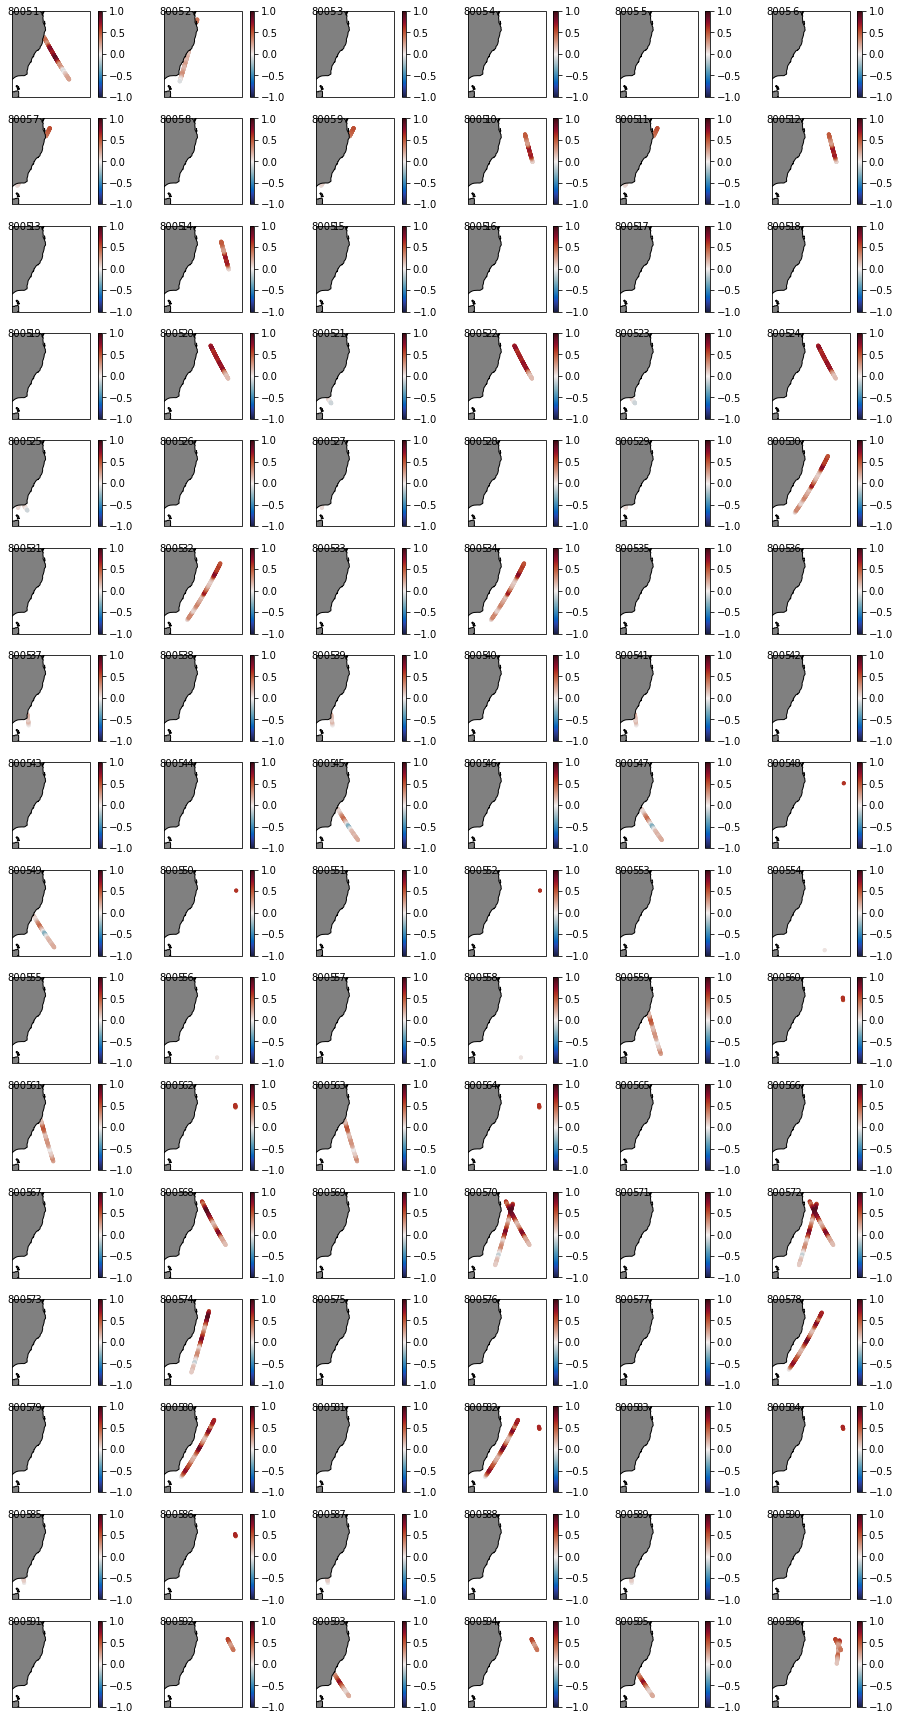

In [16]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)


for day in np.arange(dStart,dEnd,assimPeriod-assimOverlap): 
    modFileName = '0'+str(day)+'.nc'
    modPath = modFilePath+modPrefix+modFileName 
    print('opening '+modFileName)
    mod = xr.open_dataset(modPath)

    tRangeStart=np.arange(day,day+assimPeriod,1/24)
    tRangeEnd=np.arange(day+1/24,day+assimPeriod+1/24,1/24)

    fig = plt.figure(figsize=(13,24))
    iSz,jSz = (16,6)
    gs = fig.add_gridspec(iSz, jSz)

    for ax, tStart, tEnd in zip(range(iSz*jSz), tRangeStart, tRangeEnd):
        ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
        print(type(ax), round((tStart-tRangeStart[0])*24), round((tEnd-tRangeStart[0])*24))
        v=mod.obs_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tStart) & (mod.obs_time<tEnd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tStart) & (mod.obs_time<tEnd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tStart) & (mod.obs_time<tEnd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tStart) & (mod.obs_time<tEnd), drop=True)
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)#, vmin=-1, vmax=1, zorder=10)
        ax.text(.3,.95,str(round((tEnd-tRangeStart[0])*24)),horizontalalignment='center',transform=ax.transAxes)
        ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
        sc.set_clim([-1,1])
        cb = fig.colorbar(sc)
    # fig.colorbar(sc, ax=axes.ravel().tolist(),orientation='horizontal')
    plt.tight_layout()
    # plt.savefig('temp.png')


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


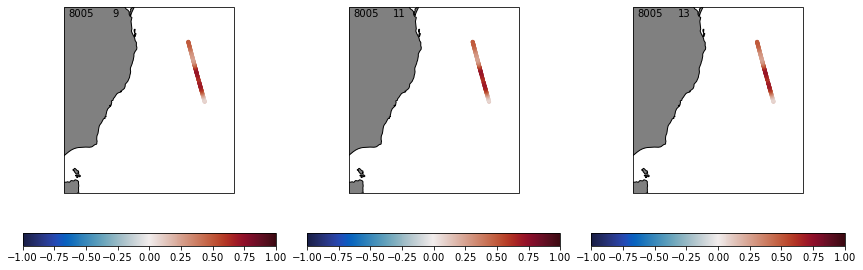

In [17]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.obs_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()


8005.375
<xarray.DataArray 'obs_value' ()>
array(0.44288304)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.44288304)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.44288304)


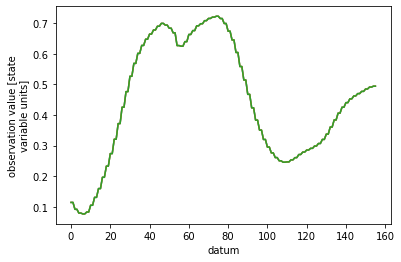

In [18]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.obs_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.36263124)


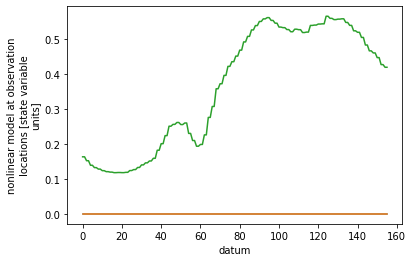

In [19]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

### Compare high res run mod file and his file.

In [20]:
modPath = '../data/raw/truth/eac_mod_08005.nc'
hisPath = '../data/raw/truth/outer_his_08005.nc'


mod = xr.open_dataset(modPath)

his = xr.open_dataset(hisPath)



In [21]:
his

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 316, eta_rho: 317, eta_u: 317, eta_v: 316, ocean_time: 31, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 271, xi_rho: 272, xi_u: 271, xi_v: 272)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2011-12-07
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/88)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    sustr          (ocean_time, eta_u, xi_u) float32 ...
    svstr          (ocean_time, eta_v, xi_v) float32 ...
    bustr          (ocean_time, eta_u, xi_u) float32 ...
    bvstr          (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Tuesday - June 15, 2021 -  9:0...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [22]:
timeRange = slice('2011-12-02 09:00:00', '2011-12-02 13:00:00')

hisInTime = his.sel(ocean_time=timeRange).isel(ocean_time=0)


In [23]:
import pandas as pd
pd.to_datetime(8005.02045,unit='d')

pd.to_datetime()

TypeError: to_datetime() missing 1 required positional argument: 'arg'

In [127]:
lst = [8005.34764204, 8005.34764606, 8005.34765007]
lstDate = []
for l in lst:
    lstDate.append(DT.timedelta(days=l))

print(lstDate)

[datetime.timedelta(days=8005, seconds=30036, microseconds=272256), datetime.timedelta(days=8005, seconds=30036, microseconds=619584), datetime.timedelta(days=8005, seconds=30036, microseconds=966048)]


<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


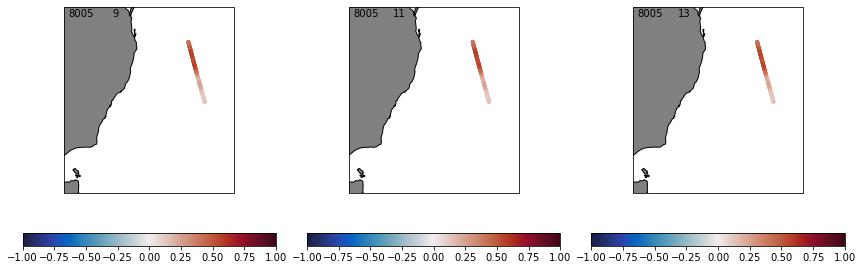

In [21]:

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()

In [87]:
    # epoch = np.datetime64('1990-01-01 00:00')
    # searchTime=np.timedelta64(int(tRangeStart*86400),'s') + epoch, print(searchTime, int(tRangeStart*86400))
    # endTime=np.timedelta64(int(tRangeStart*86400+2*3600),'s') + epoch, print(endTime, int(tRangeStart*86400+2*3600))

8005.375
<xarray.DataArray 'NLmodel_value' ()>
array(0.36306344)
8005.4583
<xarray.DataArray 'NLmodel_value' ()>
array(0.36264345)
8005.5416
<xarray.DataArray 'NLmodel_value' ()>
array(0.36429622)


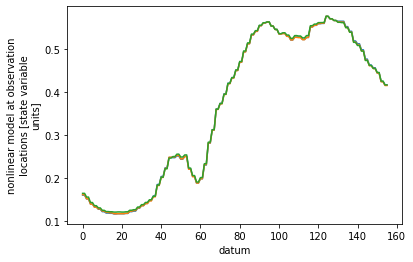

In [22]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


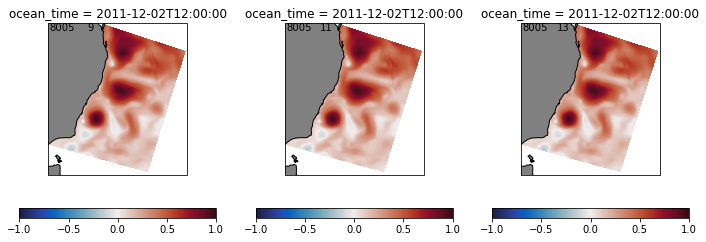

In [78]:

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)
zeta = hisInTime.zeta
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=mod.NLmodel_value.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    lo=mod.obs_lon.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    la=mod.obs_lat.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    t=mod.obs_time.where(mod.obs_provenance==pRange).where((mod.obs_time>tRangeStart) & (mod.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=zeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, vmin=-1, vmax=1, cmap=cmaps.cmocean_balance)
    # im = zeta.plot.pcolormesh()
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
# plt.tight_layout()

<ipython-input-100-2e43d07b1d7b>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value')
<ipython-input-100-2e43d07b1d7b>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value')
<xarray.DataArray 'NLmodel_value' ()>
array(0.35384032)


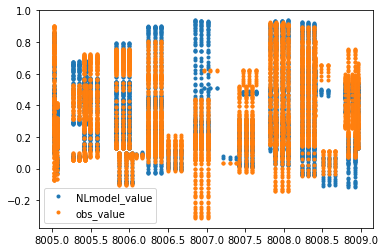

In [100]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([dStart, dEnd])
pRange=(405)


v=mod.NLmodel_value.where(mod.obs_provenance==pRange)
vobs=mod.obs_value.where(mod.obs_provenance==pRange)

lo=mod.obs_lon.where(mod.obs_provenance==pRange)
la=mod.obs_lat.where(mod.obs_provenance==pRange)
t=mod.obs_time.where(mod.obs_provenance==pRange)

fig = plt.figure()
ax = plt.axes()
ax.plot(t, v,marker='.',lineStyle='None',label='NLmodel_value')
ax.plot(t, vobs,marker='.',lineStyle='None',label='obs_value')
ax.legend()
# vobs.plot(marker='.')
print(v.mean())

### try again with new finalised obs files

In [27]:
obsPath = '../data/raw/new_truth/eac_obs_8005.nc'


obs = xr.open_dataset(obsPath)

8005.375
<xarray.DataArray 'obs_value' ()>
array(0.35933071)
8005.4583
<xarray.DataArray 'obs_value' ()>
array(0.36266427)
8005.5416
<xarray.DataArray 'obs_value' ()>
array(0.36246533)


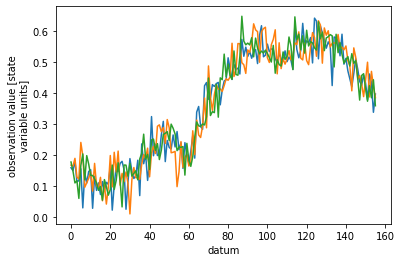

In [28]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375+aa, 8005.4583+aa, 8005.5416+aa])
pRange=(405)

for tRangeStart in tRange:
    print(tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    v.plot()
    print(v.mean())

<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.375
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.4583
<class 'cartopy.mpl.geoaxes.GeoAxesSubplot'> 8005.5416


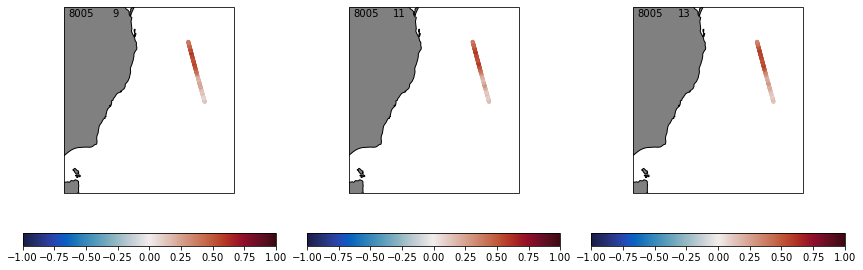

In [29]:
dStart=8005
dEnd=8009
assimPeriod = 5
assimOverlap = 1

pRange=(405)

aa=0/24
tRange=np.array([8005.375-aa, 8005.4583-aa, 8005.5416-aa])
pRange=(405)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, tRangeStart in zip(axes, tRange):
    print(type(ax), tRangeStart)
    v=obs.obs_value.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    lo=obs.obs_lon.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    la=obs.obs_lat.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    t=obs.obs_time.where(obs.obs_provenance==pRange).where((obs.obs_time>tRangeStart) & (obs.obs_time<tRangeStart+1/24), drop=True)
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance)
    ax.text(.3,.95,str(round((tRangeStart-8005)*24)),horizontalalignment='center',transform=ax.transAxes)
    ax.text(.1,.95,str(day),horizontalalignment='center',transform=ax.transAxes)
    sc.set_clim([-1,1])
    fig.colorbar(sc, ax=ax, orientation='horizontal')
plt.tight_layout()